## 一、加载常用库

In [1]:
from __future__ import print_function, division
import SimpleITK as sitk
import numpy as np
import csv
from glob import glob
import pandas as pd
import os
import scipy.ndimage
from tqdm import tqdm #进度条
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei'] #指定默认字体  
  
plt.rcParams['axes.unicode_minus'] = False #解决保存图像是负号'-'显示为方块的问题
%matplotlib inline

import matplotlib.animation as animation
from IPython.display import HTML

    
import warnings #不显示乱七八糟的warning
warnings.filterwarnings("ignore")

## 二、定义文件夹

### 2.1 数据和csv的位置，根据需要修改

In [2]:
luna_path = r'/root/Cloud/Dataset/Tianchi_MedicalAI/'
luna_subset_path = luna_path + 'sample_patients/'
file_list = glob(luna_subset_path + "*.mhd")
df_node = pd.read_csv(luna_path + '/csv/train/' + 'annotations.csv')
    

In [3]:
print(file_list)
print(df_node)

['/root/Cloud/Dataset/Tianchi_MedicalAI/sample_patients/LKDS-00001.mhd', '/root/Cloud/Dataset/Tianchi_MedicalAI/sample_patients/LKDS-00003.mhd', '/root/Cloud/Dataset/Tianchi_MedicalAI/sample_patients/LKDS-00004.mhd', '/root/Cloud/Dataset/Tianchi_MedicalAI/sample_patients/LKDS-00005.mhd', '/root/Cloud/Dataset/Tianchi_MedicalAI/sample_patients/LKDS-00007.mhd', '/root/Cloud/Dataset/Tianchi_MedicalAI/sample_patients/LKDS-00011.mhd', '/root/Cloud/Dataset/Tianchi_MedicalAI/sample_patients/LKDS-00013.mhd', '/root/Cloud/Dataset/Tianchi_MedicalAI/sample_patients/LKDS-00015.mhd', '/root/Cloud/Dataset/Tianchi_MedicalAI/sample_patients/LKDS-00016.mhd', '/root/Cloud/Dataset/Tianchi_MedicalAI/sample_patients/LKDS-00019.mhd', '/root/Cloud/Dataset/Tianchi_MedicalAI/sample_patients/LKDS-00020.mhd', '/root/Cloud/Dataset/Tianchi_MedicalAI/sample_patients/LKDS-00021.mhd', '/root/Cloud/Dataset/Tianchi_MedicalAI/sample_patients/LKDS-00023.mhd', '/root/Cloud/Dataset/Tianchi_MedicalAI/sample_patients/LKDS-000

### 2.2 临时文件和输出文件的位置

In [4]:
output_path = luna_path + 'npy/'
working_path = luna_path + 'output/'

### 2.3 检查下文件夹，如果没有的话新建

In [5]:
if os.path.isdir(luna_path + '/npy'):
    pass
else:
    os.mkdir(luna_path + '/npy')

if os.path.isdir(luna_path + '/npy/another'):
    pass
else:
    os.mkdir(luna_path + '/npy/another')
    
if os.path.isdir(luna_path + '/output'):
    pass
else:
    os.mkdir(luna_path + '/output')

## 三、定义一些函数

In [6]:
def make_mask(center,diam,z,width,height,spacing,origin): #只显示结节
    '''
Center : 圆的中心 px -- list of coordinates x,y,z
diam : 圆的直径 px -- diameter
widthXheight : pixel dim of image
spacing = mm/px conversion rate np array x,y,z
origin = x,y,z mm np.array
z = z position of slice in world coordinates mm
    '''
    mask = np.zeros([height,width]) # 0's everywhere except nodule swapping x,y to match img
    #convert to nodule space from world coordinates

    # Defining the voxel range in which the nodule falls
    v_center = (center-origin)/spacing
    v_diam = int(diam/spacing[0]+5)
    v_xmin = np.max([0,int(v_center[0]-v_diam)-5])
    v_xmax = np.min([width-1,int(v_center[0]+v_diam)+5])
    v_ymin = np.max([0,int(v_center[1]-v_diam)-5]) 
    v_ymax = np.min([height-1,int(v_center[1]+v_diam)+5])

    v_xrange = range(v_xmin,v_xmax+1)
    v_yrange = range(v_ymin,v_ymax+1)

    # Convert back to world coordinates for distance calculation
    x_data = [x*spacing[0]+origin[0] for x in range(width)]
    y_data = [x*spacing[1]+origin[1] for x in range(height)]

    # Fill in 1 within sphere around nodule
    for v_x in v_xrange:
        for v_y in v_yrange:
            p_x = spacing[0]*v_x + origin[0]
            p_y = spacing[1]*v_y + origin[1]
            if np.linalg.norm(center-np.array([p_x,p_y,z]))<=diam:
                mask[int((p_y-origin[1])/spacing[1]),int((p_x-origin[0])/spacing[0])] = 1.0
    return(mask)

def matrix2int16(matrix):
    ''' 
matrix must be a numpy array NXN
Returns uint16 version
    '''
    m_min= np.min(matrix)
    m_max= np.max(matrix)
    matrix = matrix-m_min
    return(np.array(np.rint( (matrix-m_min)/float(m_max-m_min) * 65535.0),dtype=np.uint16))


#
# Helper function to get rows in data frame associated 
# with each file
def get_filename(file_list, case):
    for f in file_list:
        if case in f:
            return(f)
#
# The locations of the nodes


def normalize(image, MIN_BOUND=-1000.0, MAX_BOUND=400.0):
    """数据标准化"""
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image > 1] = 1.
    image[image < 0] = 0.
    return image
    #---数据标准化
    
    
def set_window_width(image, MIN_BOUND=-1000.0, MAX_BOUND=400.0):
    """设置窗宽"""
    image[image > MAX_BOUND] = MAX_BOUND
    image[image < MIN_BOUND] = MIN_BOUND
    return image
    #---设置窗宽   

## 四、第一种数据处理方式（2D + 3切片）
### 4.1 将数据关联至csv

In [7]:
df_node["file"] = df_node["seriesuid"].map(lambda file_name: get_filename(file_list, file_name))
df_node = df_node.dropna()
df_node

seriesuid      coordX      coordY       coordZ  diameter_mm  \
35   LKDS-00040   79.242701  196.199649   207.500000    11.625369   
61   LKDS-00030  -90.992760   97.696849   695.299988     9.985914   
65   LKDS-00001  -76.449879  -49.540571   229.500000    14.180405   
76   LKDS-00021  -96.106988  185.268880   544.100037     7.963035   
149  LKDS-00066  112.381207  128.726884   923.500061     6.899594   
177  LKDS-00003  -82.905787  106.263573   226.224976     5.200858   
178  LKDS-00003  -92.705387  191.515214   228.724976     6.723286   
204  LKDS-00061   62.440788  232.679196   500.971373    17.642830   
230  LKDS-00058 -102.655470  108.188811   438.759995    12.227999   
236  LKDS-00050   94.474496  217.586545  1027.499939    22.180068   
250  LKDS-00013  -42.644951  -86.651939  -139.800002    15.884164   
264  LKDS-00047  -94.818434  181.964605   391.199951     8.342894   
265  LKDS-00047 -107.767578  156.728516   397.199951     4.463820   
275  LKDS-00065   48.081657 -167.684289   -72.599996    15.657926   
276  LKDS-00065   47.925566 -167.522709   -71.999996    16.447260   
286  LKDS-00007  -36.303583   68.367853    18.875000     6.347767   
304  LKDS-00004  -68.270833  209.412809   167.229885    22.517480   
353  LKDS-00051  -61.660733   34.943007   166.375000     8.136289   
400  LKDS-00035   54.344499 -121.296268  1474.000001    22.919420   
401  LKDS-00035   54.809439 -121.111550  1474.600001    22.298440   
433  LKDS-00053   78.588925  178.827551   372.800049    13.286082   
443  LKDS-00020   66.590575   40.630257   127.500000     5.501401   
444  LKDS-00020  -59.778725  -63.993566   133.750000     3.710569   
445  LKDS-00020  -91.957005   59.896153   140.000000     9.309810   
446  LKDS-00020 -112.355511   21.425644   161.250000     4.375346   
447  LKDS-00020  -95.590115  -55.689101   176.250000     4.021434   
448  LKDS-00020  117.026559   50.394807   205.000000     4.898830   
449  LKDS-00020  -72.587675   10.522515    43.750000    22.376520   
450  LKDS-00020  104.023240    0.912963    97.500000     4.552701   
451  LKDS-00020   78.402520   -6.006865   100.000000     4.411916   
..          ...         ...         ...          ...          ...   
628  LKDS-00052   29.438147   63.496942  -196.670914     5.209168   
629  LKDS-00052 -100.509793   29.321020   -97.178042     5.062185   
630  LKDS-00052 -119.283954  -23.223688  -110.817716     8.679782   
631  LKDS-00052  -89.668593   34.299059  -128.560248    23.483745   
632  LKDS-00052  -75.732970   35.285004  -185.380144     4.181188   
633  LKDS-00052 -126.162566   -0.397681  -213.322709     4.762203   
649  LKDS-00019  -71.709390  -47.089729  -218.416849     4.506690   
650  LKDS-00019   34.652929   18.541730   -79.084230     4.812693   
684  LKDS-00062 -113.522077  -36.281770  -185.275664     6.999823   
685  LKDS-00062   59.330996  -24.992374  -197.039912     8.735774   
697  LKDS-00029  104.993437   69.394252  -122.742588     5.686317   
701  LKDS-00034  -93.522635 -194.634443  -191.591941     6.134569   
746  LKDS-00042  101.801091  -28.538583  -173.260613     5.582217   
758  LKDS-00054 -106.081573  -56.189209  -179.184765     7.880768   
759  LKDS-00054   95.992672   75.810918  -193.007174     4.143870   
760  LKDS-00054 -106.607419   13.307594  -194.067306     5.108291   
761  LKDS-00054  141.269266   -4.147875  -224.022009     4.661995   
762  LKDS-00054  112.662387  -63.498803  -238.167946     7.215827   
787  LKDS-00039   44.016476   -7.920203  -249.687665     7.604463   
788  LKDS-00039  -96.960220   48.935850   -68.038429    16.977557   
793  LKDS-00005 -147.952967 -164.169479  -273.434241     5.898208   
796  LKDS-00038  121.908760  -67.415801  -158.800193     9.061650   
799  LKDS-00023 -103.950427 -156.447323  -143.950652     5.194046   
800  LKDS-00023   63.575350 -130.319172  -125.029684     4.387577   
809  LKDS-00036  -86.898448  -53.103270  -130.089157     5.118825   
822  LKDS-00011   79.240951  105.062110  -170.126775     5.838910   
823 

### 4.2 查看下数据量

In [8]:
print ('数据条数：%d' % df_node.shape[0])

数据条数：71


In [9]:
file1 = file_list[0]
print(file1)
itk_img = sitk.ReadImage(file1) 

/root/Cloud/Dataset/Tianchi_MedicalAI/sample_patients/LKDS-00001.mhd


### 4.3 转换mhd到npy（为了速度，只保留3层）

In [10]:
mini_df = df_node[df_node["file"]==file_list[0]]
mini_df
print(mini_df.shape)

(1, 6)


In [11]:
for fcount, img_file in enumerate(tqdm(file_list)):
    mini_df = df_node[df_node["file"]==img_file] #get all nodules associate with file
    if mini_df.shape[0]>0: # some files may not have a nodule--skipping those 
        # load the data once
        print(img_file)
        itk_img = sitk.ReadImage(img_file) 
        print(itk_img)
        img_array = sitk.GetArrayFromImage(itk_img) # indexes are z,y,x (notice the ordering)
        num_z, height, width = img_array.shape        #heightXwidth constitute the transverse plane
        origin = np.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
        spacing = np.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)
        # go through all nodes (why just the biggest?)
        for node_idx, cur_row in mini_df.iterrows():       
            node_x = cur_row["coordX"]
            node_y = cur_row["coordY"]
            node_z = cur_row["coordZ"]
            diam = cur_row["diameter_mm"]
            # just keep 3 slices
            imgs = np.ndarray([3,height,width],dtype=np.float32)
            masks = np.ndarray([3,height,width],dtype=np.uint8)
            center = np.array([node_x, node_y, node_z])   # nodule center
            v_center = np.rint((center-origin)/spacing)  # nodule center in voxel space (still x,y,z ordering)
            for i, i_z in enumerate(np.arange(int(v_center[2])-1,
                             int(v_center[2])+2).clip(0, num_z-1)): # clip prevents going out of bounds in Z
                mask = make_mask(center, diam, i_z*spacing[2]+origin[2],
                                 width, height, spacing, origin)
                masks[i] = mask
                imgs[i] = img_array[i_z]
                        
            
            
            np.save(os.path.join(output_path,"images_%04d_%04d.npy" % (fcount, node_idx)),imgs)
            np.save(os.path.join(output_path,"masks_%04d_%04d.npy" % (fcount, node_idx)),masks)

  0%|          | 0/40 [00:00<?, ?it/s]

/root/Cloud/Dataset/Tianchi_MedicalAI/sample_patients/LKDS-00001.mhd


  2%|▎         | 1/40 [00:01<00:39,  1.01s/it]

Image (0x49b6120)
  RTTI typeinfo:   itk::Image<short, 3u>
  Reference Count: 1
  Modified Time: 1159
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 1134
  UpdateMTime: 1158
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 281]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 281]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 281]
  Spacing: [0.806641, 0.806641, 1.25]
  Origin: [-207.5, -206.5, 49.5]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.806641 0 0
0 0.806641 0
0 0 1.25

  PointToIndexMatrix: 
1.23971 0 0
0 1.23971 0
0 0 0.8

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x49b08f0)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, short>
      Reference 

  5%|▌         | 2/40 [00:03<00:54,  1.43s/it]

/root/Cloud/Dataset/Tianchi_MedicalAI/sample_patients/LKDS-00004.mhd
Image (0x49b6120)
  RTTI typeinfo:   itk::Image<short, 3u>
  Reference Count: 1
  Modified Time: 1549
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 1524
  UpdateMTime: 1548
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 325]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 325]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 325]
  Spacing: [0.683594, 0.683594, 1]
  Origin: [-174, -12, 23]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.683594 0 0
0 0.683594 0
0 0 1

  PointToIndexMatrix: 
1.46286 0 0
0 1.46286 0
0 0 1

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x49b08f0)
      RTTI typeinfo:   itk::Impor

  8%|▊         | 3/40 [00:04<00:53,  1.44s/it]

/root/Cloud/Dataset/Tianchi_MedicalAI/sample_patients/LKDS-00005.mhd


 10%|█         | 4/40 [00:06<00:52,  1.46s/it]

Image (0x49c20d0)
  RTTI typeinfo:   itk::Image<short, 3u>
  Reference Count: 1
  Modified Time: 1744
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 1719
  UpdateMTime: 1743
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 419]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 419]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 419]
  Spacing: [0.652344, 0.652344, 0.7]
  Origin: [-170.674, -326.674, -377.5]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.652344 0 0
0 0.652344 0
0 0 0.7

  PointToIndexMatrix: 
1.53293 0 0
0 1.53293 0
0 0 1.42857

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x49a1980)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, short>
      Re

 12%|█▎        | 5/40 [00:08<00:59,  1.70s/it]

/root/Cloud/Dataset/Tianchi_MedicalAI/sample_patients/LKDS-00011.mhd


 15%|█▌        | 6/40 [00:09<00:49,  1.45s/it]

Image (0x49c20d0)
  RTTI typeinfo:   itk::Image<short, 3u>
  Reference Count: 1
  Modified Time: 2134
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 2109
  UpdateMTime: 2133
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 253]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 253]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 253]
  Spacing: [0.601562, 0.601562, 1.25]
  Origin: [-133.8, -133.3, -341.54]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.601562 0 0
0 0.601562 0
0 0 1.25

  PointToIndexMatrix: 
1.66234 0 0
0 1.66234 0
0 0 0.8

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x49a1980)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, short>
      Referen

 18%|█▊        | 7/40 [00:11<00:48,  1.48s/it]

/root/Cloud/Dataset/Tianchi_MedicalAI/sample_patients/LKDS-00015.mhd


 20%|██        | 8/40 [00:12<00:48,  1.52s/it]

Image (0x49c20d0)
  RTTI typeinfo:   itk::Image<short, 3u>
  Reference Count: 1
  Modified Time: 2524
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 2499
  UpdateMTime: 2523
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 389]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 389]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 389]
  Spacing: [0.712891, 0.712891, 1]
  Origin: [-202.144, -346.644, -31.2]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.712891 0 0
0 0.712891 0
0 0 1

  PointToIndexMatrix: 
1.40274 0 0
0 1.40274 0
0 0 1

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x490cf90)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, short>
      Reference Cou

 22%|██▎       | 9/40 [00:14<00:51,  1.66s/it]

/root/Cloud/Dataset/Tianchi_MedicalAI/sample_patients/LKDS-00019.mhd
Image (0x49c20d0)
  RTTI typeinfo:   itk::Image<short, 3u>
  Reference Count: 1
  Modified Time: 2914
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 2889
  UpdateMTime: 2913
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 240]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 240]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 240]
  Spacing: [0.566406, 0.566406, 1.25]
  Origin: [-164.2, -114.4, -342.75]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.566406 0 0
0 0.566406 0
0 0 1.25

  PointToIndexMatrix: 
1.76552 0 0
0 1.76552 0
0 0 0.8

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x2925750)
      RTTI type

 25%|██▌       | 10/40 [00:15<00:43,  1.46s/it]

/root/Cloud/Dataset/Tianchi_MedicalAI/sample_patients/LKDS-00020.mhd
Image (0x49b6120)
  RTTI typeinfo:   itk::Image<short, 3u>
  Reference Count: 1
  Modified Time: 3109
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 3084
  UpdateMTime: 3108
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 221]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 221]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 221]
  Spacing: [0.664062, 0.664062, 1.25]
  Origin: [-170.5, -170, -5]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.664062 0 0
0 0.664062 0
0 0 1.25

  PointToIndexMatrix: 
1.50588 0 0
0 1.50588 0
0 0 0.8

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x462a020)
      RTTI typeinfo:  

 28%|██▊       | 11/40 [00:17<00:46,  1.60s/it]

/root/Cloud/Dataset/Tianchi_MedicalAI/sample_patients/LKDS-00021.mhd
Image (0x49c20d0)
  RTTI typeinfo:   itk::Image<short, 3u>
  Reference Count: 1
  Modified Time: 3304
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 3279
  UpdateMTime: 3303
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 441]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 441]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 441]
  Spacing: [0.683594, 0.683594, 0.625]
  Origin: [-167, -32, 354.1]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.683594 0 0
0 0.683594 0
0 0 0.625

  PointToIndexMatrix: 
1.46286 0 0
0 1.46286 0
0 0 1.6

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x2925750)
      RTTI typeinfo:

 30%|███       | 12/40 [00:19<00:45,  1.64s/it]

/root/Cloud/Dataset/Tianchi_MedicalAI/sample_patients/LKDS-00023.mhd


 32%|███▎      | 13/40 [00:20<00:38,  1.43s/it]

Image (0x49b6120)
  RTTI typeinfo:   itk::Image<short, 3u>
  Reference Count: 1
  Modified Time: 3499
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 3474
  UpdateMTime: 3498
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 197]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 197]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 197]
  Spacing: [0.625, 0.625, 1.8]
  Origin: [-159.688, -351.688, -400.3]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.625 0 0
0 0.625 0
0 0 1.8

  PointToIndexMatrix: 
1.6 0 0
0 1.6 0
0 0 0.555556

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x490cf90)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, short>
      Reference Count: 1
  

 35%|███▌      | 14/40 [00:20<00:29,  1.14s/it]

Image (0x49c20d0)
  RTTI typeinfo:   itk::Image<short, 3u>
  Reference Count: 1
  Modified Time: 3694
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 3669
  UpdateMTime: 3693
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 133]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 133]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 133]
  Spacing: [0.742188, 0.742188, 2.5]
  Origin: [-207.3, -190, -366.5]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.742188 0 0
0 0.742188 0
0 0 2.5

  PointToIndexMatrix: 
1.34737 0 0
0 1.34737 0
0 0 0.4

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x2925750)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, short>
      Reference Co

 38%|███▊      | 15/40 [00:22<00:32,  1.28s/it]

/root/Cloud/Dataset/Tianchi_MedicalAI/sample_patients/LKDS-00028.mhd


 40%|████      | 16/40 [00:23<00:29,  1.23s/it]

Image (0x49c20d0)
  RTTI typeinfo:   itk::Image<short, 3u>
  Reference Count: 1
  Modified Time: 4084
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 4059
  UpdateMTime: 4083
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 325]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 325]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 325]
  Spacing: [0.611328, 0.611328, 1]
  Origin: [-160.5, -52.2845, 1539]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.611328 0 0
0 0.611328 0
0 0 1

  PointToIndexMatrix: 
1.63578 0 0
0 1.63578 0
0 0 1

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x364dfb0)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, short>
      Reference Count:

 42%|████▎     | 17/40 [00:24<00:30,  1.32s/it]

/root/Cloud/Dataset/Tianchi_MedicalAI/sample_patients/LKDS-00030.mhd


 45%|████▌     | 18/40 [00:26<00:28,  1.30s/it]

Image (0x49c20d0)
  RTTI typeinfo:   itk::Image<short, 3u>
  Reference Count: 1
  Modified Time: 4474
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 4449
  UpdateMTime: 4473
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 334]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 334]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 334]
  Spacing: [0.777344, 0.777344, 1]
  Origin: [-216, -30, 554.3]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.777344 0 0
0 0.777344 0
0 0 1

  PointToIndexMatrix: 
1.28643 0 0
0 1.28643 0
0 0 1

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x29253c0)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, short>
      Reference Count: 1
   

 48%|████▊     | 19/40 [00:26<00:23,  1.12s/it]

Image (0x49b6120)
  RTTI typeinfo:   itk::Image<short, 3u>
  Reference Count: 1
  Modified Time: 4669
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 4644
  UpdateMTime: 4668
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 192]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 192]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 192]
  Spacing: [0.664063, 0.664063, 1.8]
  Origin: [-168.668, -307.668, -405.8]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.664063 0 0
0 0.664063 0
0 0 1.8

  PointToIndexMatrix: 
1.50588 0 0
0 1.50588 0
0 0 0.555556

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x490cf90)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, short>
      R

 50%|█████     | 20/40 [00:29<00:30,  1.51s/it]

/root/Cloud/Dataset/Tianchi_MedicalAI/sample_patients/LKDS-00036.mhd


 52%|█████▎    | 21/40 [00:30<00:26,  1.39s/it]

Image (0x49b6120)
  RTTI typeinfo:   itk::Image<short, 3u>
  Reference Count: 1
  Modified Time: 5059
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 5034
  UpdateMTime: 5058
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 270]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 270]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 270]
  Spacing: [0.603516, 0.603516, 1.25]
  Origin: [-143.6, -159.2, -362.89]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.603516 0 0
0 0.603516 0
0 0 1.25

  PointToIndexMatrix: 
1.65696 0 0
0 1.65696 0
0 0 0.8

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x45cfc10)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, short>
      Referen

 55%|█████▌    | 22/40 [00:32<00:26,  1.49s/it]

/root/Cloud/Dataset/Tianchi_MedicalAI/sample_patients/LKDS-00039.mhd
Image (0x49b6120)
  RTTI typeinfo:   itk::Image<short, 3u>
  Reference Count: 1
  Modified Time: 5449
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 5424
  UpdateMTime: 5448
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 272]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 272]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 272]
  Spacing: [0.742188, 0.742188, 1.25]
  Origin: [-214.4, -180.2, -354.5]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.742188 0 0
0 0.742188 0
0 0 1.25

  PointToIndexMatrix: 
1.34737 0 0
0 1.34737 0
0 0 0.8

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x4940730)
      RTTI typei

 57%|█████▊    | 23/40 [00:33<00:25,  1.49s/it]

/root/Cloud/Dataset/Tianchi_MedicalAI/sample_patients/LKDS-00040.mhd
Image (0x49c20d0)
  RTTI typeinfo:   itk::Image<short, 3u>
  Reference Count: 1
  Modified Time: 5644
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 5619
  UpdateMTime: 5643
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 329]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 329]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 329]
  Spacing: [0.683594, 0.683594, 1]
  Origin: [-178, -22, 42.5]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.683594 0 0
0 0.683594 0
0 0 1

  PointToIndexMatrix: 
1.46286 0 0
0 1.46286 0
0 0 1

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x3acab80)
      RTTI typeinfo:   itk::Imp

 60%|██████    | 24/40 [00:35<00:24,  1.51s/it]

/root/Cloud/Dataset/Tianchi_MedicalAI/sample_patients/LKDS-00041.mhd


 62%|██████▎   | 25/40 [00:36<00:19,  1.31s/it]

Image (0x49b6120)
  RTTI typeinfo:   itk::Image<short, 3u>
  Reference Count: 1
  Modified Time: 5839
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 5814
  UpdateMTime: 5838
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 181]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 181]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 181]
  Spacing: [0.722656, 0.722656, 1.8]
  Origin: [-178.639, -349.639, -349]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.722656 0 0
0 0.722656 0
0 0 1.8

  PointToIndexMatrix: 
1.38378 0 0
0 1.38378 0
0 0 0.555556

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x28ebbd0)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, short>
      Ref

 65%|██████▌   | 26/40 [00:37<00:20,  1.43s/it]

Image (0x49c20d0)
  RTTI typeinfo:   itk::Image<short, 3u>
  Reference Count: 1
  Modified Time: 6034
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 6009
  UpdateMTime: 6033
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 564]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 564]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 564]
  Spacing: [0.703125, 0.703125, 0.625]
  Origin: [-186.2, -180, -349.02]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.703125 0 0
0 0.703125 0
0 0 0.625

  PointToIndexMatrix: 
1.42222 0 0
0 1.42222 0
0 0 1.6

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x2f53bb0)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, short>
      Referen

 68%|██████▊   | 27/40 [00:38<00:16,  1.23s/it]

/root/Cloud/Dataset/Tianchi_MedicalAI/sample_patients/LKDS-00044.mhd


 70%|███████   | 28/40 [00:39<00:14,  1.21s/it]

Image (0x49c20d0)
  RTTI typeinfo:   itk::Image<short, 3u>
  Reference Count: 1
  Modified Time: 6424
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 6399
  UpdateMTime: 6423
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 280]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 280]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 280]
  Spacing: [0.710938, 0.710938, 1]
  Origin: [-166.439, -36.1953, -817.2]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.710938 0 0
0 0.710938 0
0 0 1

  PointToIndexMatrix: 
1.40659 0 0
0 1.40659 0
0 0 1

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x49c19a0)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, short>
      Reference Co

 72%|███████▎  | 29/40 [00:41<00:14,  1.27s/it]

/root/Cloud/Dataset/Tianchi_MedicalAI/sample_patients/LKDS-00050.mhd
Image (0x49c20d0)
  RTTI typeinfo:   itk::Image<short, 3u>
  Reference Count: 1
  Modified Time: 6814
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 6789
  UpdateMTime: 6813
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 356]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 356]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 356]
  Spacing: [0.761719, 0.761719, 1]
  Origin: [-196, -73, 801.5]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.761719 0 0
0 0.761719 0
0 0 1

  PointToIndexMatrix: 
1.31282 0 0
0 1.31282 0
0 0 1

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x490cf90)
      RTTI typeinfo:   itk::Im

 75%|███████▌  | 30/40 [00:43<00:14,  1.46s/it]

/root/Cloud/Dataset/Tianchi_MedicalAI/sample_patients/LKDS-00051.mhd


 78%|███████▊  | 31/40 [00:44<00:13,  1.46s/it]

Image (0x49b6120)
  RTTI typeinfo:   itk::Image<short, 3u>
  Reference Count: 1
  Modified Time: 7009
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 6984
  UpdateMTime: 7008
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 461]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 461]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 461]
  Spacing: [0.703125, 0.703125, 0.625]
  Origin: [-164, -180, 37]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.703125 0 0
0 0.703125 0
0 0 0.625

  PointToIndexMatrix: 
1.42222 0 0
0 1.42222 0
0 0 1.6

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x49c19a0)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, short>
      Reference Coun

 80%|████████  | 32/40 [00:45<00:10,  1.35s/it]

/root/Cloud/Dataset/Tianchi_MedicalAI/sample_patients/LKDS-00053.mhd


 82%|████████▎ | 33/40 [00:46<00:09,  1.31s/it]

Image (0x49b6120)
  RTTI typeinfo:   itk::Image<short, 3u>
  Reference Count: 1
  Modified Time: 7400
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 7375
  UpdateMTime: 7399
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 291]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 291]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 291]
  Spacing: [0.683594, 0.683594, 1]
  Origin: [-178, -25, 261.8]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.683594 0 0
0 0.683594 0
0 0 1

  PointToIndexMatrix: 
1.46286 0 0
0 1.46286 0
0 0 1

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x462a020)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, short>
      Reference Count: 1
   

 85%|████████▌ | 34/40 [00:47<00:07,  1.22s/it]

/root/Cloud/Dataset/Tianchi_MedicalAI/sample_patients/LKDS-00058.mhd


 88%|████████▊ | 35/40 [00:49<00:06,  1.27s/it]

Image (0x49b6120)
  RTTI typeinfo:   itk::Image<short, 3u>
  Reference Count: 1
  Modified Time: 7790
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 7765
  UpdateMTime: 7789
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 385]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 385]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 385]
  Spacing: [0.769531, 0.769531, 1]
  Origin: [-198.97, -44.4, 236.76]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.769531 0 0
0 0.769531 0
0 0 1

  PointToIndexMatrix: 
1.29949 0 0
0 1.29949 0
0 0 1

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x490dba0)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, short>
      Reference Count:

 90%|█████████ | 36/40 [00:50<00:04,  1.22s/it]

/root/Cloud/Dataset/Tianchi_MedicalAI/sample_patients/LKDS-00062.mhd
Image (0x49b6120)
  RTTI typeinfo:   itk::Image<short, 3u>
  Reference Count: 1
  Modified Time: 8180
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 8155
  UpdateMTime: 8179
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 163]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 163]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 163]
  Spacing: [0.585938, 0.585938, 2]
  Origin: [-166.6, -150, -316.345]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.585938 0 0
0 0.585938 0
0 0 2

  PointToIndexMatrix: 
1.70667 0 0
0 1.70667 0
0 0 0.5

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x49e96c0)
      RTTI typeinfo:  

 92%|█████████▎| 37/40 [00:51<00:03,  1.10s/it]

/root/Cloud/Dataset/Tianchi_MedicalAI/sample_patients/LKDS-00064.mhd
Image (0x49c20d0)
  RTTI typeinfo:   itk::Image<short, 3u>
  Reference Count: 1
  Modified Time: 8375
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 8350
  UpdateMTime: 8374
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 541]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 541]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 541]
  Spacing: [0.78125, 0.78125, 0.625]
  Origin: [-206.2, -208.3, -295.61]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.78125 0 0
0 0.78125 0
0 0 0.625

  PointToIndexMatrix: 
1.28 0 0
0 1.28 0
0 0 1.6

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x49b08f0)
      RTTI typeinfo:   

 95%|█████████▌| 38/40 [00:53<00:02,  1.34s/it]

/root/Cloud/Dataset/Tianchi_MedicalAI/sample_patients/LKDS-00065.mhd
Image (0x49b6120)
  RTTI typeinfo:   itk::Image<short, 3u>
  Reference Count: 1
  Modified Time: 8570
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 8545
  UpdateMTime: 8569
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 450]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 450]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 450]
  Spacing: [0.726563, 0.726563, 0.6]
  Origin: [-188.637, -293.637, -183]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.726563 0 0
0 0.726563 0
0 0 0.6

  PointToIndexMatrix: 
1.37634 0 0
0 1.37634 0
0 0 1.66667

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x49a1980)
      RTTI t

 98%|█████████▊| 39/40 [00:55<00:01,  1.54s/it]

/root/Cloud/Dataset/Tianchi_MedicalAI/sample_patients/LKDS-00066.mhd


100%|██████████| 40/40 [00:56<00:00,  1.43s/it]

Image (0x49c20d0)
  RTTI typeinfo:   itk::Image<short, 3u>
  Reference Count: 1
  Modified Time: 8765
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 8740
  UpdateMTime: 8764
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 338]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 338]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 338]
  Spacing: [0.796875, 0.796875, 1]
  Origin: [-204, -52, 723.5]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.796875 0 0
0 0.796875 0
0 0 1

  PointToIndexMatrix: 
1.2549 0 0
0 1.2549 0
0 0 1

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x49b08f0)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, short>
      Reference Count: 1
     

## 五、可视化
### 5.1 看下最后一张CT的所有图片

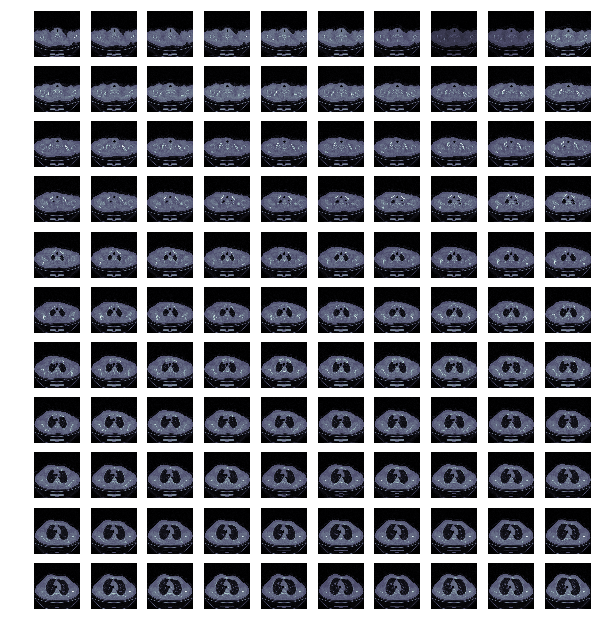

In [12]:
f, plots = plt.subplots(11, 10, sharex='all', sharey='all', figsize=(10, 11))
# matplotlib is drunk

for i in range(110):
    plots[i // 10, i % 10].axis('off')
    plots[i // 10, i % 10].imshow(img_array[i], cmap=plt.cm.bone)

### 5.2 来个动图看下

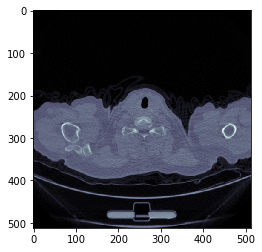

In [13]:
# Based on @Zombie's code
fig = plt.figure()


anim = plt.imshow(img_array[0], cmap=plt.cm.bone)

def update(i):
    anim.set_array(img_array[i])
    return anim,


# HTML(animation.FuncAnimation(fig, update, frames=range(len(img_array)), interval=50, blit=True).to_html5_video())

### 5.3 看下保留下来的3层的样子

图片的第 0 层


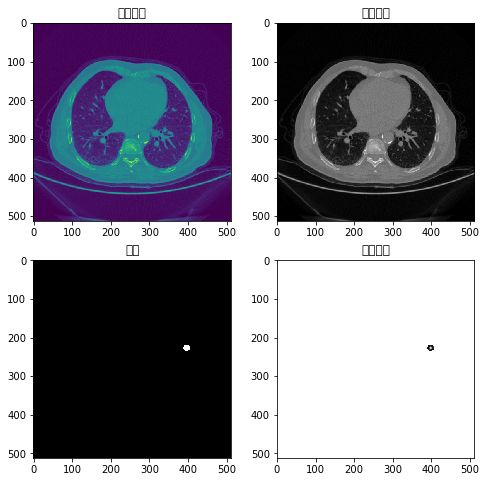




图片的第 1 层


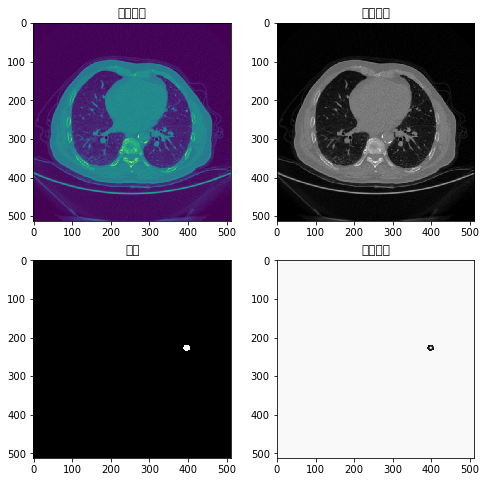




图片的第 2 层


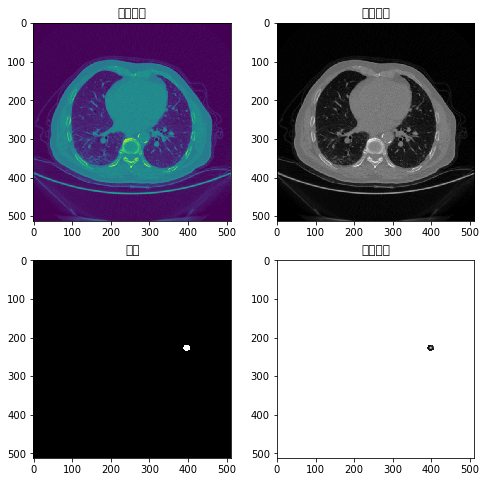

In [14]:
imgs = np.load(os.path.join(output_path,"images_%04d_%04d.npy" % (fcount, node_idx)))
masks = np.load(os.path.join(output_path,"masks_%04d_%04d.npy" % (fcount, node_idx)))

for i in range(len(imgs)):
    print ("图片的第 %d 层" % i)
    fig,ax = plt.subplots(2,2,figsize=[8,8])
    ax[0,0].imshow(imgs[i])
    ax[0,0].set_title(u'彩色切片')
    ax[0,1].imshow(imgs[i],cmap='gray')
    ax[0,1].set_title(u'黑白切片')
    ax[1,0].imshow(masks[i],cmap='gray')
    ax[1,0].set_title(u'节点')
    ax[1,1].imshow(imgs[i]*masks[i],cmap='gray')
    ax[1,1].set_title(u'节点切片')
    plt.show()
    print ('\n\n')
#    raw_input("hit enter to cont : ")

## 六、第二种数据处理方式（2D + 1切片+增强）

100%|██████████| 40/40 [01:03<00:00,  1.58s/it]


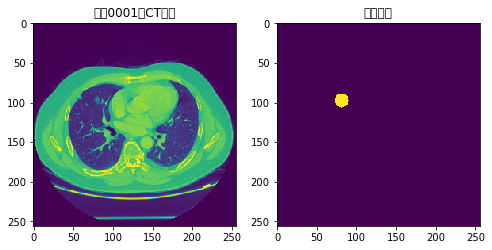

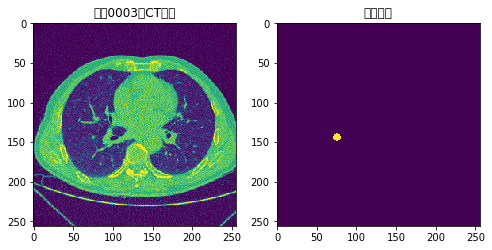

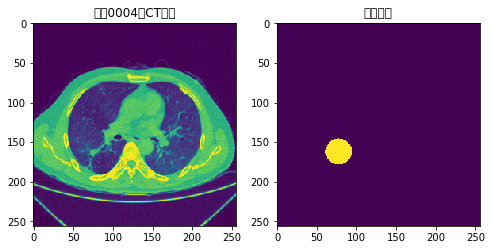

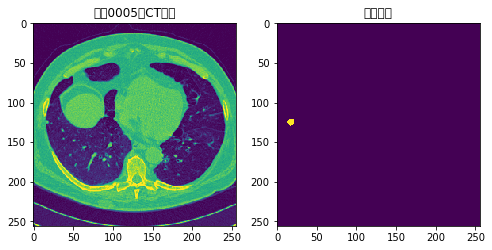

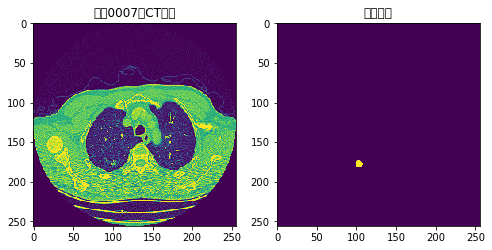

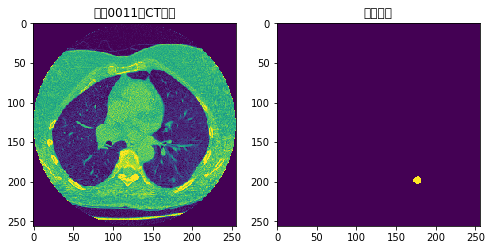

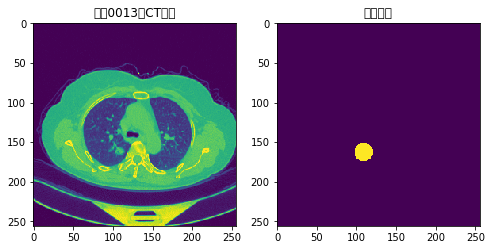

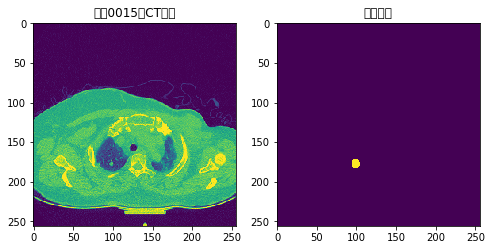

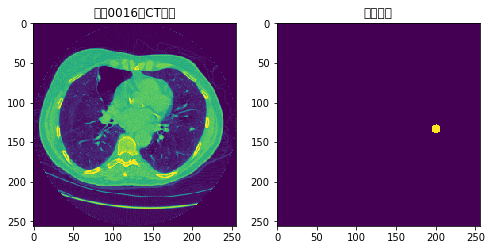

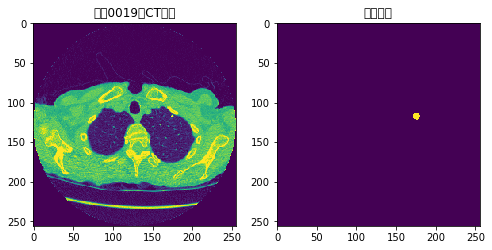

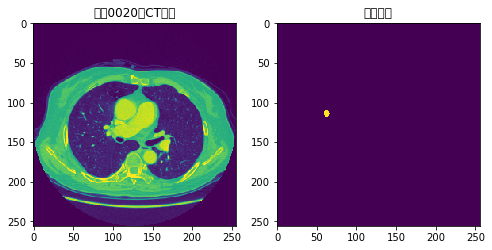

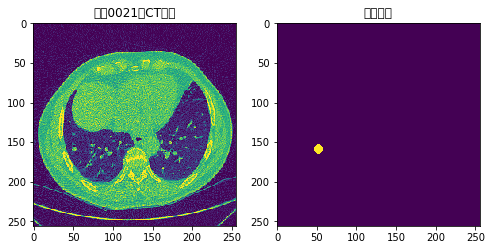

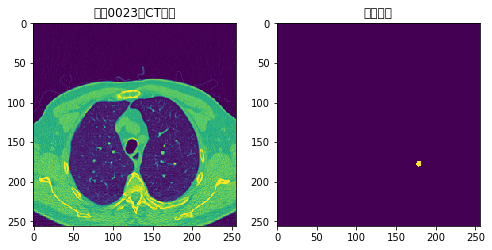

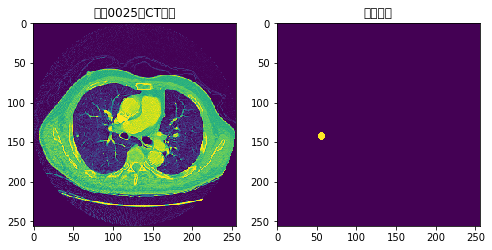

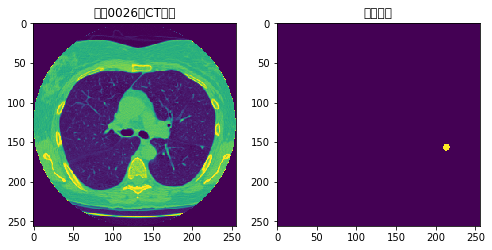

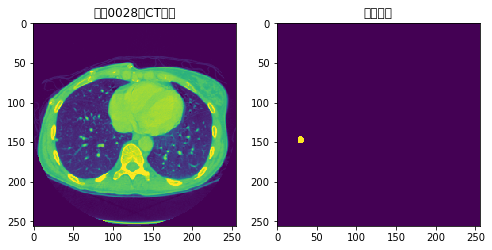

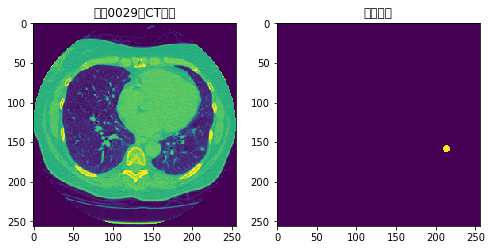

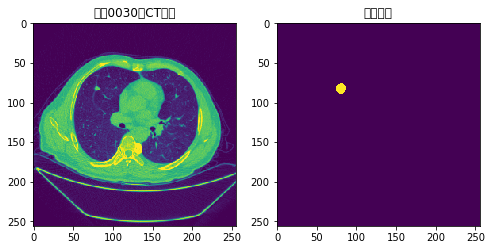

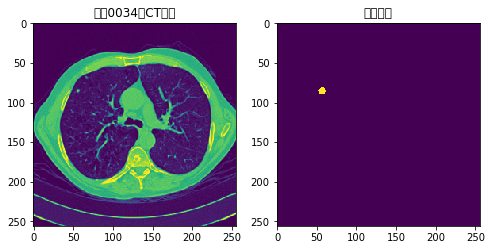

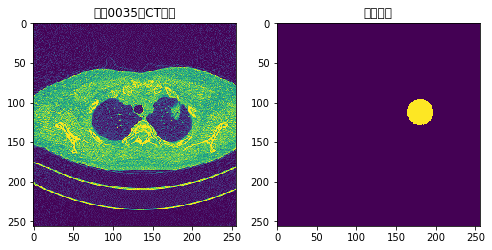

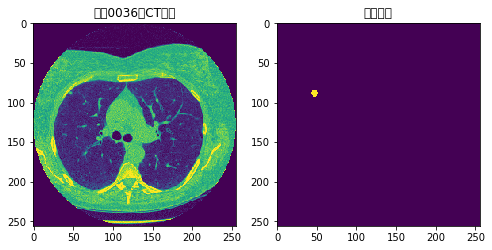

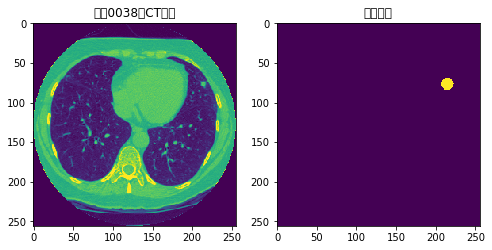

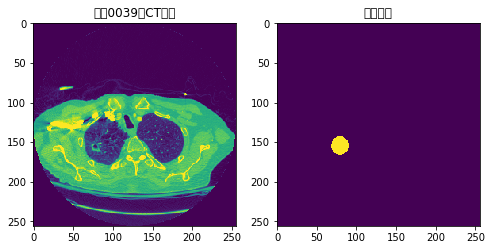

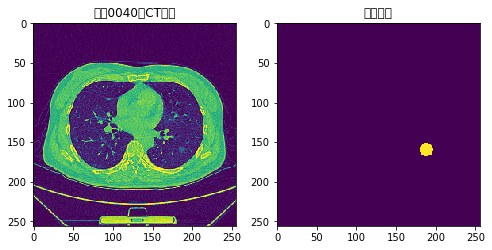

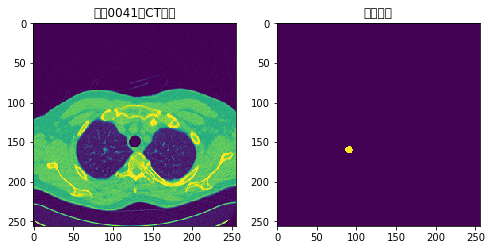

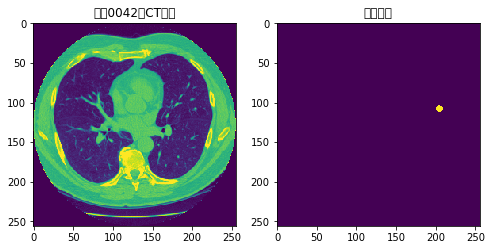

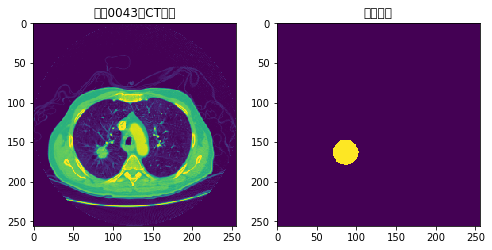

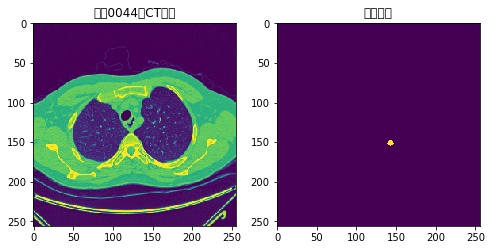

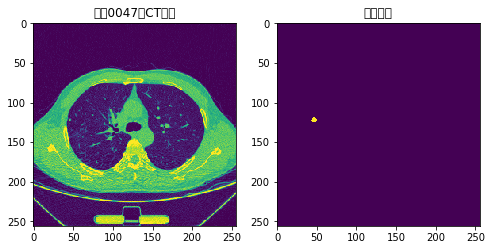

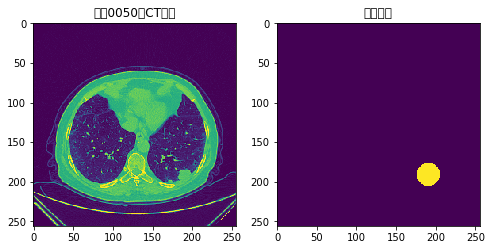

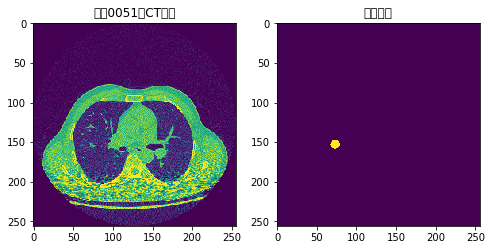

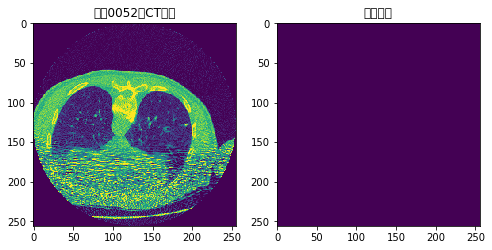

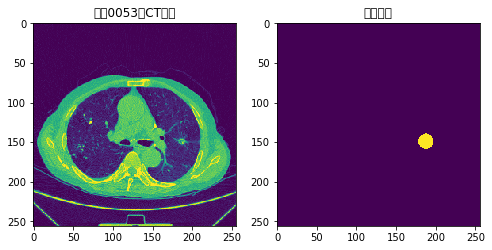

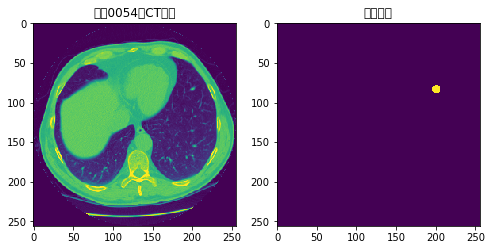

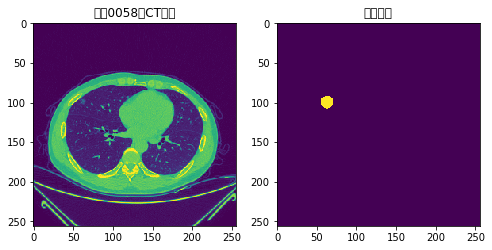

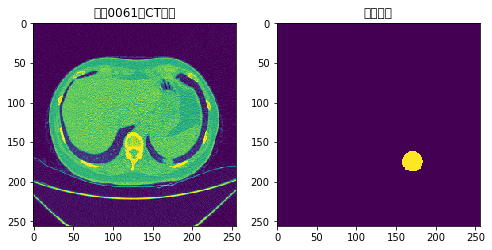

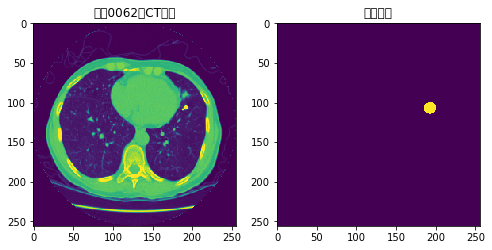

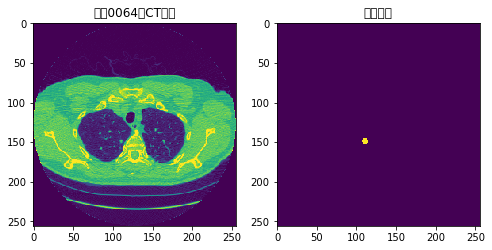

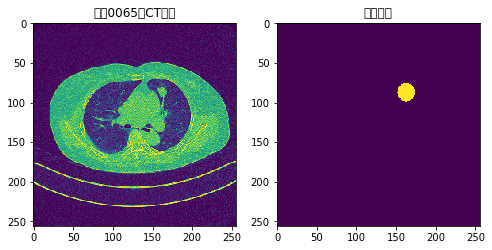

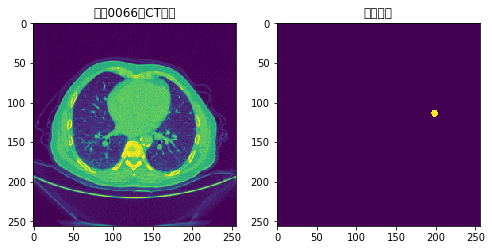

In [15]:
for fcount, img_file in enumerate(tqdm(file_list)):
    mini_df = df_node[df_node["file"]==img_file] #get all nodules associate with file
    if mini_df.shape[0]>0: # some files may not have a nodule--skipping those 
        # load the data once
        itk_img = sitk.ReadImage(img_file) 
        img_array = sitk.GetArrayFromImage(itk_img) # indexes are z,y,x (notice the ordering)
        num_z, height, width = img_array.shape        #heightXwidth constitute the transverse plane
        origin = np.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
        spacing = np.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)
        # go through all nodes (why just the biggest?)
        for node_idx, cur_row in mini_df.iterrows():       
            node_x = cur_row["coordX"]
            node_y = cur_row["coordY"]
            node_z = cur_row["coordZ"]
            diam = cur_row["diameter_mm"]

            w_nodule_center = np.array([node_x, node_y, node_z])   # 世界空间中结节中心的坐标
            v_nodule_center = np.rint((w_nodule_center - origin) / spacing)   # 体素空间中结节中心的坐标 (still x,y,z ordering)
            # np.rint 对浮点数取整，但不改变浮点数类型
            # for i, i_z in enumerate(np.arange(int(v_nodule_center[2]) - 1,int(v_nodule_center[2]) + 2).clip(0,num_z - 1)):  # clip 方法的作用是防止超出切片数量的范围
            i_z = int(v_nodule_center[2])
            nodule_mask = make_mask(w_nodule_center, diam, i_z * spacing[2] + origin[2],width, height, spacing, origin)
            nodule_mask = scipy.ndimage.interpolation.zoom(nodule_mask, [0.5, 0.5], mode='nearest')
            nodule_mask[nodule_mask<0.5] = 0
            nodule_mask[nodule_mask > 0.5] = 1
            nodule_mask = nodule_mask.astype('int8')
            slice = img_array[i_z]
            slice = scipy.ndimage.interpolation.zoom(slice, [0.5, 0.5], mode='nearest')
            slice = 255.0 * normalize(slice)
            slice = slice.astype(np.uint8)#---因为int16有点大，我们改成了uint8图（值域0~255）

            np.save(os.path.join(output_path, "another/%s_%04d_%04d_%04d.npy" % (cur_row["seriesuid"],fcount, node_idx,i_z)), slice)
            np.save(os.path.join(output_path, "another/%s_%04d_%04d_%04d_mask.npy" % (cur_row["seriesuid"],fcount, node_idx,i_z)),nodule_mask)
            
            
        fig,ax = plt.subplots(1,2,figsize=[8,8])
        
        aa = np.load(os.path.join(output_path, "another/%s_%04d_%04d_%04d.npy" % (cur_row["seriesuid"],fcount, node_idx,i_z)))
        bb = np.load(os.path.join(output_path, "another/%s_%04d_%04d_%04d_mask.npy" % (cur_row["seriesuid"],fcount, node_idx,i_z)))
        
        ax[0].imshow(aa)
        ax[0].set_title(u'病例' + cur_row["seriesuid"][-4:] + u'的CT扫描')
        ax[1].imshow(bb)
        ax[1].set_title(u'结节位置')

## 七、第三种数据处理方式（3D）
### 7.1 胸腔

In [ ]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [ ]:
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

In [20]:
def plot_3d(image, threshold=0):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces = measure.marching_cubes_classic(p,threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()


plot_3d(pix_resampled, 400)

NameError: name 'img_array' is not defined

### 7.2 肺部

In [ ]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
  
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

In [ ]:
segmented_lungs = segment_lung_mask(pix_resampled, False)
segmented_lungs_fill = segment_lung_mask(pix_resampled, True)

### 7.2.1 肺部所有结构

In [ ]:
plot_3d(segmented_lungs_fill, 0)

### 7.2.2 肺部主要结构

In [ ]:
plot_3d(segmented_lungs, 0)

### 7.2.3 支气管和结节

In [ ]:
plot_3d(segmented_lungs_fill - segmented_lungs, 0)